# Análisis de Sentimientos en Español Escrito mediante Machine Learning

- Nicolás Fredes 
- Diego Lazcano
- Iván Opitz

## Descargar Tweets para crear el modelo
El programa "tweet4.py" se encarga de descargar tweets y pre procesarlos, dejándolos listos para usarlos en la creación del modelo. Este programa guarda, en un archivo llamado dataTweet, los tweets descargados como una lista de listas, en que cada una de las listas dentro de esta lista principal es un tweet pre procesado. Los elementos de la lista correspondiente a cada tweew son las palabras de dicho tweet. 

El pre procesado se hace utilizando el programa "ppsing.py". En este programa se toma el texto del tweet y se realizan las siguientes acciones: 

- Dado que viene con el URL de si mismo al final del texto, fue necesario eliminarlo para que no afecte al modelo.

- Pasa todas las letras a minúsculas. Esto para que el modelo no considere a dos palabras iguales, una escrita con mayúsculas      y otra con minúsculas, como palabras diferentes.

- Elimina todos los símbolos (!, ", #, &, (, ), etc).

- Elimina todas las stop words (o palabras vacías).

- Lematiza verbos para que el hecho de tener diferentes morfemas no implique que se consideren como palabras diferentes.

- Singulariza sustantivos y adjetivos para que no tome a una palabra singular y su respectivo plural como palabras diferentes.

In [2]:
%run -i tweet4.py

cantidad de frases:2
bajando...

guardado...
9
fin



# Word2Vec
Word2Vec es un algoritmo de Word embedding, lo que permite transformar palabras en vectores considerando su contenido y relación semantica, este consiste en tres capas de neuronas, una de entrada, capa interna y de salida, donde la activación de la capa intermedia es lineal, y la activación de la capa de salida esta dada por una función softmax, la cual busca disminuir la entropía en la determinación de la salida, maximizando la probabilidad de que esta sea mapeada, de forma one hot encoding, en el mismo vector en el que fue codificada en la capa de entrada.

Existen dos modelos importantes para Word2Vec, CBOW (bolsa de palabras) y Skip-Gram, donde la primera busca establecer en la capa de salida, palabras relacionadas a un conjunto de otras palabras en la capa de entrada (busca palabras dado un contexto), y el segundo busca determinar un conjunto de palabras o contexto en la capa de entrada, dadas varias palabras sematicamente similares en la capa de salida (busca contexto dado palabras).


# Creación del modelo.
En esta sección veremos la forma en que, utilizando lo obtenido de "tweet4.py", podemos entrenar nuestro modelo utilizando la función Word2Vec, implementada en la libreria de python llamada gensim.

Los parametros que utilizamos para esta función fueron los siguientes:

- sg = 1. Si sg vale 1 entonces se utiliza skip-gram para entrenar el modelo. En otro caso se usa CBOW.
- size = 400. Size indica la dimención de cada vector obtenido con el modelo.
- window = 5. Indica la cantidad de palabras dentro de una oración usadas para la predicción de cada palabra.
- min_count = 50. Indica la cantidad minima de veces que debe aparecer una palabra en el corpus para que sea tomada en cuenta en el modelo.
- workers = -1. Indica la cantidad de hilos que se van a ocupar para entrenar el modelo. -1 indica que se van a usar todos los disponibles.
- negative = 15. Indica la cantidad de pablaras negativas a considerar al entrenar para cada palabra en el modelo (palabras no relacionadas con la palabra original y que deben ser mapeadas a 0).
- iter = 10000. Indica el numero de epocas a utilizar sobre el corpus.

La función cuenta con otros parametros que dejamos por defecto. Para mas detalles ver el siguiente link: https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/word2vec.py

In [1]:
from gensim.models import Word2Vec
import pickle

infile = open('datareal','rb')
oraciones = pickle.load(infile)
infile.close()

modelo = Word2Vec(oraciones, sg=1,size=400,window=5,min_count=20,workers=-1,negative=15,iter=10000)

modelo.save('modelo_prueba')

C:\Users\Nicolas\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Signed spectral clustering

Este algoritmo es una modificación de Spectral Clustering, el cual esta diseñado para hacer clusters en Grafos $G=(V,W)$, con los vertices $V=\{v_{1},...,v_{m}\}$ y matriz de afinidad $W$, este algoritmo se basa en dos partes importantes. La primera es Spectral embedding, el cual encuentra los vectores que minimizan el funcional:
$$min_{X}\{tr(X^{T}LX)\}$$
$$sujeto\, a\,\, X^{T}DX=I$$
Donde $D$ es una matriz diagonal cuyos elementos son $d_{i}=d_{i}(v_{i})=\sum_{j=1}^{m}|w_{ij}|$, y $L$ es el laplaciano definido como $L=D-W$.

Una vez realizado el spectral embedding, la segunda parte consiste en utilizar el $discretice$ para encontrar una matriz cuyos elementos son 1 y 0, e indican a que cluster corresponde cada palabra del vocabulario.
La diferencia con Signed Spectral Clustering, es que este admite pesos $w_{ij}$ negativos para la matriz de afinidad W, lo que se ve reflejado en un suerte anti relación entre palabras, lo que permite separar los antonimos al momento del clustering, a pesar de que estos aparezcan muy proximos en el espacio vectorial por su similaridad semantica, el cual es uno de los mayores problemas de Word2Vec. El calculo de $D$ y $L$ son iguales pero se diferencian es que estos poseen signo.

## Definir matriz de afinidad W
Una de las partes importantes de este algoritmo es definir la matriz de afinidad, la cual en forma estandar se inicializa (W_init) aplicando algún kernel sobre el espacio vectorial, y asignando cada elemento de dicha matriz como función de cada par posible de vectores, por ejemplo:
$$w_{ij}=e^{\dfrac{||v_{i}-v_{j}||_{2}}{\sigma}}$$
Donde $w_{ij}$ es el elemento $i,j$ de la matriz $W$ y $v_{i},v_{j}$ son los vectores correspondientes a las palabras de la posición $i,j$ del vocabulario, respectivamente.

Posteriormente para la consideración del signo se utiliza un Tesaurio que entrega una lista de relaciones de antonimos y sininomos entre algunas palabras del vocabulario. Cada lista se traduce en un matriz T_syn y T_ant, la primera entrega un 1 entre pares de sinonimos, la segunda un -1 entre pares de antonimos, y ambas arrojan 0 en cualquier otro caso. Finalmente, se setea una matriz de afinidad que porta la información del modelo vectorial pasado por algun kernel (gausseano, cosine, entre otros posibles), combinado con la información del tesaurio, de la siguiente forma:

$$W = \alpha \; W_{init} + \beta_{syn}\; W_{init} \circ T_{syn} + \beta_{ant}\; W_{init} \circ T_{ant}$$

Es esta W la que se entrega al Signed Spectral clustering para la creación de los clusters. Los hiperparametros $\alpha$, $\beta_{syn}$, $\beta_{ant}$ son escalares que deben ser seteados bajo algun criterio de optimización, y el operador $\circ$ corresponde al producto de Hadamard. 



## Creación de clusters


In [2]:
from gensim.models import Word2Vec
import pickle
import wordgraph

try:
    vocab = list(modelo.wv.vocab.keys())
except:
    modelo = Word2Vec.load('modelo_prueba')
    vocab = list(modelo.wv.vocab.keys())
kwds=dict()
kwds['gamma']=1/0.002

T_sin,T_ant = wordgraph.T_syn_ant(vocab)


In [4]:
#las siguientes matrices, se colocan separadas ya que W_gauss requiere mas calculo
W_gauss = wordgraph.W_init(modelo[vocab],kernel='gaus',**kwds)
W_final = wordgraph.W(W_gauss,T_ant,T_sin,0.5,1.0,1.0)

##guardar matriz de afinidad
outfile=open('W_final','wb')
pickle.dump(W_final,outfile)
outfile.close()

C:\Users\Nicolas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [1]:
# También es posible cargar directamente la matriz de afinidad ya guardada.
import pickle
infile=open('W_final','rb')
W_final=pickle.load(infile)
infile.close()

In [5]:
#Se generan los clusters para la matriz de afinidad obtenida.
#Este calculo requiere de un tiempo no despreciable, por lo que en el siguiente recuadro se ofrece cargar el archivo guardado.
from Signed_clustering import signed_spectral_clustering as ssc

clusters=ssc(W_final,n_clusters=300)

##guardar clusters
outfile=open('clusters','wb')
pickle.dump(clusters,outfile)
outfile.close()

In [4]:
#También es posible cargar directamente los clusters anteriormente guardados.
infile=open('clusters','rb')
clusters=pickle.load(infile)
infile.close()

In [6]:
#Las siguientes funciones entregan caracteristicas de los clusters realizados 
import metrics

# indica el costo del modelo: la cantidad de sinonimos en clusters opuestos y 
# antonimos en mismo clusters
cost=metrics.metric(T_ant,T_sin,clusters)
print("el costo es",cost,'\n')

# Esta funcion entrega un arrai con la cantidad de elemento de cada cluster
dist=metrics.distribution(clusters)
print(dist)
print('\n')

#indica los elementos del cluster en que esta la palabra
word='amor'
metrics.show_cluster (vocab,clusters,word)

el costo es 1361 

[198, 10, 12, 13, 7, 8, 10, 40, 10, 7, 9, 9, 13, 6, 6, 64, 8, 12, 9, 8, 45, 23, 3, 6, 10, 9, 15, 30, 16, 19, 14, 6, 4, 13, 8, 7, 12, 55, 12, 9, 63, 11, 6, 12, 126, 12, 35, 92, 104, 8, 13, 10, 105, 5, 9, 16, 18, 13, 13, 10, 5, 9, 16, 11, 7, 9, 12, 7, 10, 23, 135, 51, 19, 11, 33, 12, 15, 9, 13, 13, 75, 7, 10, 13, 34, 68, 17, 10, 17, 11, 6, 9, 13, 101, 14, 15, 15, 14, 10, 11, 12, 105, 9, 10, 8, 16, 85, 10, 16, 13, 9, 5, 9, 11, 100, 11, 13, 18, 16, 16, 44, 9, 13, 103, 10, 12, 7, 7, 15, 11, 10, 5, 10, 29, 13, 38, 16, 8, 66, 9, 10, 10, 11, 8, 11, 129, 11, 37, 93, 11, 25, 49, 11, 7, 48, 5, 38, 11, 44, 36, 44, 11, 12, 13, 59, 7, 14, 54, 27, 7, 56, 5, 5, 8, 8, 54, 12, 11, 90, 16, 9, 13, 9, 60, 12, 7, 6, 16, 14, 55, 57, 5, 55, 10, 26, 9, 60, 33, 4, 45, 52, 16, 10, 59, 11, 121, 9, 102, 12, 93, 10, 8, 19, 79, 49, 9, 105, 17, 91, 4, 9, 53, 84, 9, 48, 10, 43, 8, 11, 81, 6, 10, 34, 36, 14, 41, 46, 12, 108, 41, 46, 33, 67, 6, 40, 57, 118, 9, 7, 21, 86, 87, 80, 48, 45, 8, 103, 94, 62

['corazón',
 'amor',
 'paraíso',
 'cielo',
 'sol',
 'gusto',
 'cariño',
 'simpatía',
 'ternura',
 'sabor',
 'afecto']

# Asignación de Frase
Un problema fundamental de la implementación final, es determinar cual es el cluster más representativo según la frase, para ello se debe tener en cuenta que cada frase es un conjunto de nodos, por lo cual se decide calcular el promedio entre los enlaces positivos, negativos, positivos del complemento, y negativos del complemento para cualquier cluster, donde el complemento son los otros clusters.

Realizar esto requiere ir recorriendo de forma iterativa la matriz de afinidad por cada palabra, lo que en tiempo real se traduce a un algoritmo bastante lento. Para disminuir el tiempo de ejecución en timepo real, se decidio generar tablas (diccionarios) donde el indice son los cluster y posee la información de la suma de los elementos negativos y positivos por palabra. Por ejemplo sea $H$ la tabla y se desea encontrar la suma de los enlaces positivos del nodo $v_{i}$, para el cluster $c_{x}$ entonces se debe recorrer la tabla de la siguiente forma:
$$H\rightarrow c_{i}  \rightarrow pos\rightarrow i = \sum_{v_{i},v_{j}\in c_{x}}w_{ij}$$

Además la tabla guarda información sobre la cantidad de elementos engativos y positivos de un cluster para el calculo del promedio.

In [7]:
# creacion de la tabla denominada links
#senti_labeles son los clusters de interes (sentimentales), si no se coloca nada entonces
#calcula la tabla por todos los clusters
import metrics
links=metrics.links_clusters (W_final,clusters,senti_labels=None)



Una vez creada la tabla, pueden existir distintas maneras de evaluar la frase con los clusters, nosotros definimos ocupar el siguiente funcional:
$$\bar{X}_{+}(frase,C_{x})+\bar{X}_{-}(frase,C_{x}^{C})-\bar{X}_{+}(frase,C_{x}^{C})-\bar{X}_{-}(frase,C_{x})$$
Donde $\bar{X}_{+}(A,B)$ es el promedio de todos los enlaces positivos entre $A$ y $B$, y $\bar{X}_{-}(A,B)$, es el promedio de todos los enlaces negativos entre $A$ y $B$ en valor absoluto. Por lo tanto se elige el cluster $C$, tal que el funcional sea mas grande.


In [12]:
# simCluster entrega un diccionario donde la llave son los cluster
from ppsing import ptext
oracion=ptext('Te odio! Eres insoportable, feo y tonto.')
print(oracion)
func=metrics.simCluster(vocab,oracion[0],links)

[['te', 'odio', 'ser', 'insoportable', 'feo', 'y', 'tonto']]


In [14]:
cluster_word=metrics.dict_cluster(vocab,clusters)
label=metrics.position(func)

print('El cluster más similar dado por:\n',cluster_word[label])
print('Además, el valor de su funcional es',func[label])

El cluster más similar dado por:
 ['básico', 'sencillo', 'estúpido', 'animal', 'fauna', 'simple', 'tonto', 'bruto', 'bestia', 'imbécil', 'idiota', 'memo', 'burro']
Además, el valor de su funcional es 0.5002966036496921


# Análisis de sentimientos

Una vez que se posee la tabla links y los clusters de algun modelo respectivo, es posible crear etiquetas para estos clusters, es decir, es posible asignarle manualmente el calificativo de negativo, positivo o neutro, esto también se podría realizar de otra forma, por ejemplo se podría asignar las etiquetas correspondientes a una gama más amplia de sentimientos, o de inclinaciones politicas, puesto que con los clusters creados las relaciones semanticas ya estan presentes, y basta una simple inspección del cluster para clasificarlo segun alguna definición de categorias pre establecidas. Esto corresponden a una semi supervisión del problema en cuestión, puesto que solo es necesaria la clasificación manual del numero de clusters (del orden de cientos), que es considerablemente inferior al tamaño del vocabulario (del orden de decenas de miles). Teniendo así que asignar aproximadamente el 2% de etiquetas que se necesitarían si uno afrontase el problema de manera totalmente supervisada desde el principio.

Por simplicidad se utilizó solo las categorias de positivo, negativo y neutro, para analizar los sentimientos de alguna frase o tweet. Para abordar esto se crearon ciertos modelos claves, a los cuales se les calculó sus clusters respectivos y se creo un diccionario para cada uno, el cual contiene que clusters corresponden a cada una de las categorias ya mencionadas. A continuación se ilustran dos de estos  modelos y se realiza el análisis de sentimientos respectivo.
 
Es importante notar que esto se podría realizar con cualquier modelo que se cree posteriormente, pero sera necesario pasar por el proceso de clasificación de los clusters, para la creación del diccionario que posee las categorías (class_clusters), de forma manual.

In [15]:
# MODELO 1
#El vocabulario, links y class_cluster posterior corresponde a un modelo creado con 1 millon de frases, el cual mediante
# un kernel basado en la distancia cosine, combinado con una lupa exponencial (como la que se ocupa en el kernel gaussiano)
# forma la matriz W final, a la cual se le calculan 300 clusters que son posteriormente categorizados en class_clusters.
# Para mayor detalle revisar readme de la carpeta version_2 (carpeta correspondiente a este modelo, sus clusters, etc.)

import wordgraph as wg
import sentiment_analysis as sa

clusters_1 = wg.load_matrix('clusters_g')
vocab_1 = wg.load_matrix('vocab_g')
links_1 = wg.load_matrix('links_g')
class_clusters_1 = wg.load_matrix('class_clusters_g')

#Es posible analizar cualquier frase en cuestión, para esto es necesaria definirla como frase de la siguiente manera,
frase = 'Te amo con todo mi corazon, eres lo mejor de mi vida.'

#Luego se procede a sus análisis de sentimientos

sa.senti_tweet(vocab=vocab_1,links=links_1,class_clusters=class_clusters_1,tweet=frase)

El tweet se considera sentimentalmente positivo.

Además posee la carga porcentual por sentimiento de, positivo: 33.6138474835983%, negativo: 32.90686238150698%, neutro: 33.479290134894725%.


{'negativo': 0.3855031182376159,
 'neutro': 0.39220909589474856,
 'positivo': 0.3937854320676}

In [16]:
#Si se desea explorar la calidad de esto clusters se puede revisar donde queda cada palabra de la siguiente forma
import metrics
#indica los elementos del cluster en que esta la palabra
word='amor'
metrics.show_cluster (vocab_1,clusters_1,word)

['corazón',
 'centro',
 'enlace',
 'pasión',
 'amor',
 'paraíso',
 'cielo',
 'sol',
 'intimidad',
 'aventura',
 'ojo',
 'gusto',
 'núcleo',
 'cariñito',
 'cariño',
 'amado',
 'simpatía',
 'ternura',
 'bondad',
 'esencia',
 'afecto',
 'caricia',
 'apego']

In [17]:
# MODELO 2
#El vocabulario, links y class_cluster posterior corresponde a un modelo creado con 245.376 frases, el cual mediante
# un kernel gaussiano de Sklearn forma la matriz W final, a la cual se le calculan 300 clusters que son posteriormente
# categorizados en class_clusters. 
# Para mayor detalle revisar readme de la carpeta version_4 (carpeta correspondiente a este modelo, sus clusters, etc.)

import wordgraph as wg
import sentiment_analysis as sa

clusters_2 = wg.load_matrix('clusters_i')
vocab_2 = wg.load_matrix('vocab_i')
links_2 = wg.load_matrix('links_i')
class_clusters_2 = wg.load_matrix('class_clusters_i')

#Es posible analizar cualquier frase en cuestión, para esto es necesaria definirla como frase de la siguiente manera,
frase = 'Te amo con todo mi corazon, eres lo mejor de mi vida.'

#Luego se procede a sus análisis de sentimientos

sa.senti_tweet(vocab=vocab_2,links=links_2,class_clusters=class_clusters_2,tweet=frase)

El tweet se considera sentimentalmente positivo.

Además posee la carga porcentual por sentimiento de, positivo: 33.8527418465483%, negativo: 32.411452083372524%, neutro: 33.735806070079185%.


{'negativo': 0.3646413749486437,
 'neutro': 0.3795408696516032,
 'positivo': 0.3808564423757965}

In [18]:
#Si se desea explorar la calidad de esto clusters se puede revisar donde queda cada palabra de la siguiente forma
import metrics
#indica los elementos del cluster en que esta la palabra
word='amor'
metrics.show_cluster(vocab_2,clusters_2,word)

['corazón',
 'enlace',
 'pasión',
 'amor',
 'paraíso',
 'entusiasmo',
 'cielo',
 'sol',
 'romance',
 'aventura',
 'gusto',
 'cariño',
 'simpatía',
 'ternura',
 'sabor',
 'bondad',
 'afecto']

# Matrices de Confusión

Para analizar el rango de acierto u error del análisis de sentimientos, se seleccionaron 285 tweets reales, y se clasificaron manualmente como positivos, negativos o neutros. Luego de esto, para cada uno de los tweets selecionados, se comparo esta clasificación manual con el resultado de analizar sentimentalmente dicho tweet con la funciones creadas, para así saber que tan proximo es el resultado obtenido del real, y así poder formar las matrices de confusión.

Para esto se formo un archivo tweets_clasificados que posee un diccionario con llaves 'positivo', 'negativo' y 'neutro', en cada una se encuentra un lista de tweets previamente clasificados, cuya carga emocional se corresponde con la llave del diccionario en la que se encuentra.

Es importante notar que para poder comparar los resultados de tweets_clasificados y las funciones de análisis sentimental, se debe poseer un modelo con los clusters ya clasificados (class_clusters), por lo cual se procede a calcular las matrices de confusión para los mismos 2 modelos utilizados en la sección de Análisis de sentimientos.

In [19]:
# Si se desea revisar los tweets y su respectiva clasificación se puede cargar el archivo y acceder a sus elementos
import wordgraph as wg
tweets_clas = wg.load_matrix('tweets_clasificados')
print(tweets_clas['positivo']) # también se puede acceder a 'negativo' y 'neutro'


['En solidaridad con los vecinos de Ñuñoa, apoyemos este Malón ciudadano participando en él https://t.co/FjuyO6xZbh', 'Yaaa,buenas noches\n10-4', 'Campeón de la clase obrera: https://t.co/1gdtFYUS8g', 'Fue grato verte!!! https://t.co/TfW1msN9KC', 'La @clausanhueza la mejor!!! https://t.co/wWe5EaJaEQ', 'Aun esta viva', 'La amo demasiado https://t.co/hFynzUh2zn', 'Hoy fue un dia tan lindito y espero que mañana sea mejor! ❤️', 'Buen punto https://t.co/wRc7lOaFPE', 'Este martes 14 en Cabo Blanco Cocina &amp; Taller. Los secretos de la cocina árabe palestina !\nUna vez mas compartiremos sabores y aromas del medio oriente ! \nTaller lleno !\nGracias… https://t.co/7kqNbLOSKT', '@eamarines87 Buenas noches!!', '@Chikor1a_ @___babykofii Jeje gracias por entender.', 'No dejes que las cosas que quieres te hagan olvidar de las cosas que tienes', 'Gran concierto imperdible!!. Ya falta poco para disfrutar de toda la música y poesía de éste gran artista. https://t.co/cyrMTrfM7z', 'Quiero mi casa', '@e

In [24]:
################### MODELO 1
#Se procede a comparar la clasificación presente en tweets_clasificados, con aquella que realiza la función senti_tweets.
#Es importante notar que se necesita analizar cientos de frases, por lo cual es lento.
# Para facilitar el proceso es posible saltar este paso y cargar la comparación ya calculada, en el recuadro siguiente.
import wordgraph as wg
import sentiment_analysis as sa

tweets_clas = wg.load_matrix('tweets_clasificados')
vocab_1 = wg.load_matrix('vocab_g')
links_1 = wg.load_matrix('links_g')
class_clusters_1 = wg.load_matrix('class_clusters_g')

class_result_1,result_1 = sa.test(tweets_clas,vocab_1,links_1,class_clusters_1)
print(class_result_1)

{'positivo': {'positivo': 44, 'neutro': 31, 'negativo': 21}, 'negativo': {'positivo': 46, 'negativo': 25, 'neutro': 24}, 'neutro': {'neutro': 22, 'positivo': 57, 'negativo': 15}}


In [20]:
################### MODELO 1
# Para evitar el lento calculo anterior, se puede cargar directamente el class_result ya calculado y guardado.
# El diccionario class_result contiene la información de cuantos tweets positivos presentes en tweets_clasificados
# han sido clasificados por senti_tweet como positivo, negativo o neutro, y así sucesivamente para cada estado emocional.
import wordgraph as wg

class_result_1 = wg.load_matrix('class_result_g')
print(class_result_1)

{'positivo': {'positivo': 44, 'neutro': 31, 'negativo': 21}, 'negativo': {'positivo': 46, 'negativo': 25, 'neutro': 24}, 'neutro': {'neutro': 22, 'positivo': 57, 'negativo': 15}}


El modelo 1 posee un porcentaje de acierto de  31.93 %. Adicionalmente, su matriz de confusión esta dada por,
Normalized confusion matrix
[[0.45833333 0.32291667 0.21875   ]
 [0.60638298 0.23404255 0.15957447]
 [0.48421053 0.25263158 0.26315789]]


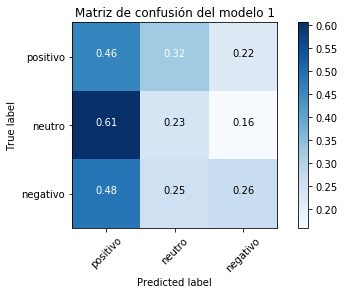

In [22]:
################### MODELO 1
# Con el class_result ya calculado o cargado es posible crear la matriz de confusión.
# Además se puede calcular el porcentaje de acierto del modelo.
import plot
import numpy as np

p = 'positivo'
n = 'negativo'
a = 'neutro'
    
data_1 = np.array([[class_result_1[p][p],class_result_1[p][a],class_result_1[p][n]],
                [class_result_1[a][p],class_result_1[a][a],class_result_1[a][n]],
                [class_result_1[n][p],class_result_1[n][a],class_result_1[n][n]]])

#Se calcula cuantos tweets fueron clasificados por senti_tweet identicamente a como estan en tweets_clasificados
# y se divide por la cantidad total de tweets analizados para saber la razon de acierto.

acierto_1 = (np.matrix.trace(data_1))/np.sum(data_1)

print('El modelo 1 posee un porcentaje de acierto de ',round(acierto_1*100,2),'%. Adicionalmente, su matriz de confusión esta dada por,')

#Se crea la matriz de confusión del modelo

plot.plot(data_1,'Matriz de confusión del modelo 1')

In [53]:
################### MODELO 2
#Se procede a comparar la clasificación presente en tweets_clasificados, con aquella que realiza la función senti_tweets.
#Es importante notar que se necesita analizar cientos de frases, por lo cual es lento.
# Para facilitar el proceso es posible saltar este paso y cargar la comparación ya calculada, en el recuadro siguiente.
import wordgraph as wg
import sentiment_analysis as sa

tweets_clas = wg.load_matrix('tweets_clasificados')
vocab_2 = wg.load_matrix('vocab_i')
links_2 = wg.load_matrix('links_i')
class_clusters_2 = wg.load_matrix('class_clusters_i')

class_result_2,result_2 = sa.test(tweets_clas,vocab_2,links_2,class_clusters_2)
print(class_result_2)

{'positivo': {'negativo': 20, 'neutro': 23, 'positivo': 53}, 'negativo': {'positivo': 44, 'neutro': 23, 'negativo': 28}, 'neutro': {'negativo': 14, 'neutro': 34, 'positivo': 46}}


In [23]:
################### MODELO 2
# Para evitar el lento calculo anterior, se puede cargar directamente el class_result ya calculado y guardado.
# El diccionario class_result contiene la información de cuantos tweets positivos presentes en tweets_clasificados
# han sido clasificados por senti_tweet como positivo, negativo o neutro, y así sucesivamente para cada estado emocional.
import wordgraph as wg

class_result_2 = wg.load_matrix('class_result_i')
print(class_result_2)

{'positivo': {'negativo': 20, 'neutro': 23, 'positivo': 53}, 'negativo': {'positivo': 44, 'neutro': 23, 'negativo': 28}, 'neutro': {'negativo': 14, 'neutro': 34, 'positivo': 46}}


El modelo 2 posee un porcentaje de acierto de  40.35 %. Adicionalmente, su matriz de confusión esta dada por,
Normalized confusion matrix
[[0.55208333 0.23958333 0.20833333]
 [0.4893617  0.36170213 0.14893617]
 [0.46315789 0.24210526 0.29473684]]


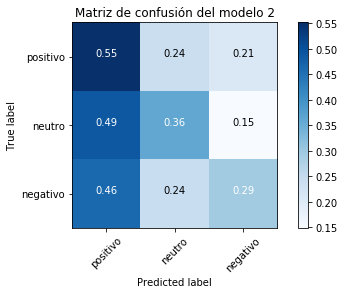

In [24]:
################### MODELO 2
# Con el class_result ya calculado o cargado es posible crear la matriz de confusión.
# Además se puede calcular el porcentaje de acierto del modelo.
import plot
import numpy as np

p = 'positivo'
n = 'negativo'
a = 'neutro'
    
data_2 = np.array([[class_result_2[p][p],class_result_2[p][a],class_result_2[p][n]],
                [class_result_2[a][p],class_result_2[a][a],class_result_2[a][n]],
                [class_result_2[n][p],class_result_2[n][a],class_result_2[n][n]]])

#Se calcula cuantos tweets fueron clasificados por senti_tweet identicamente a como estan en tweets_clasificados
# y se divide por la cantidad total de tweets analizados para saber la razon de acierto.

acierto_2 = (np.matrix.trace(data_2))/np.sum(data_2)

print('El modelo 2 posee un porcentaje de acierto de ',round(acierto_2*100,2),'%. Adicionalmente, su matriz de confusión esta dada por,')

#Se crea la matriz de confusión del modelo

plot.plot(data_2,'Matriz de confusión del modelo 2')

# Bibliografía

1) Twepy, librería de Python para acceder a Twitter API. http://www.tweepy.org/

2) Gensim, librería para la creación y manejo de Word2Vec. https://radimrehurek.com/gensim/models/word2vec.html

3) Sklearn, desarrollador de librerías de multiples usos. Se utilizaron diversas funciones de esta librería para paralelizar
 el calculo de matrices, y resolver problemas de optimización discretos asociados a Signed Spectral Clustering. http://scikit-learn.org
 
4) La implementación de Signed Spectral Clustering y la utilización de sus conceptos para el calculo de funcionales y el mapeo de clusters, fue de desarrollo propio. Sin embargo, la teoría subyacente fue extraída de los siguientes papers. 

- Semantic Word Clusters Using Signed Spectral Clustering. Joao Sedoc, Jean Gallier, Lyle Ungar, University of Pennsylvania. Dean Foster, Amazon LLC. August 2017.

- Signed Laplacian for Spectral Clustering Revisited. Knyazev, A. TR2017-001 January 2017.

- Multiclass Spectral Clustering. Stella Yu, Carnegie Mellon University. Jianbo Shi, University of Pennsylvania. 2003.